## アルゴリズムの選択

 実業務で利用されることが多い処理パターンである「分類」を対象

 　よく利用される代表的なアルゴリズムと選び方

 　アルゴリズムの中身については、詳しく説明しないがチューニング方法などをしっておくと便利

 　代表的なアルゴリズム

**実装方式　・・・　損失関数型**

　　　　・ロジスティック回帰　・・・　「シグモイド関数」の出力を確率と見なす. 境界は直線

　　　　・サポートベクターマシン(SVM)「カーネル型」 ・・・　カーネルトリックという方法で、直線以外の境界を実装
 
   ・ニューラルネットワーク(NN) ・・・　隠れ層を追加することで直線以外の境界を実現

**実装方式・・・決定木型**

   ・決定木 ・・・　　特定の項目値を基準にしたグループ訳を複数回実施

   ・ランダムフォレスト ・・・　学習データのサブセットから複数の決定木を作り、多数決で決定

   ・XGBoost ・・・　分類がうまくいかなかったデータから分類するモデルを作り、精度を向上

In [ ]:
# 日本語化ライブラリの導入

!pip install japanize-matplotlib | tail -n 1

# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# ライブりのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#matplotlibの日本語化対応
import japanize_matplotlib

#データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# NumPyの不動招集点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
#データフレームで全ての項目を表示
pd.set_option("display.max_columns", None)
#グラフのデフォルトフォントの指定
plt.rcParams["font.size"] = 14
#乱数の種
random_seed = 123

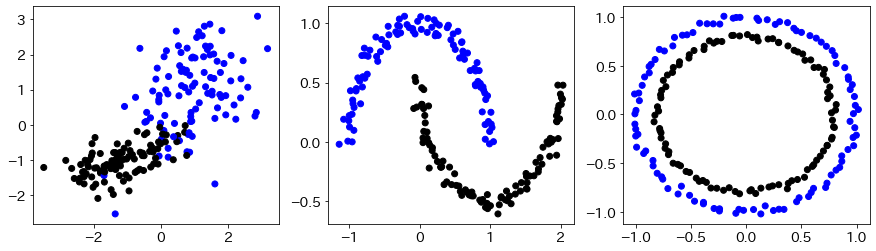

In [ ]:
# ライブラリインポート
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

# 線形分離型
X1, y1 =  make_classification(n_features=2, n_redundant=0, n_informative=2, random_state = random_seed,
                              n_clusters_per_class=1, n_samples=200, n_classes=2)

#　三日月型 (線形分離不可能)
X2, y2 = make_moons(noise=0.05, random_state=random_seed, n_samples=200)

# 円形 (線形分離不可)
X3, y3 = make_circles(n_samples=200, noise=0.02, random_state=random_seed)

#３種類のデータをDataListに保存
DataList = [(X1, y1), (X2, y2), (X3, y3)]

# N: データの種類数
N = len(DataList)

#散布図表示
plt.figure(figsize=(15,4))

# カラーマップ定義
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#0000FF', '#000000'])

for i, data in enumerate(DataList):
  X, y = data
  ax = plt.subplot(1, N, i+1)
  ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap)

plt.show()

## ロジスティック回帰

ステップ1 入力変数を１次関数にかけて中間の値uを計算する

$ u = w_{0}+w_{1}x_{1} + w_{2}x_{2} $

ステップ２　１次関数の計算結果uを「シグモイド関数」にかける。　 \\
この関数は、０から１までの値を撮るので、結果は確率値と解釈できる

ステップ３ 確率値yの値が0.5より大きい場合は, 値1を, 0.5より小さいばあいは値０を予想値とする
 

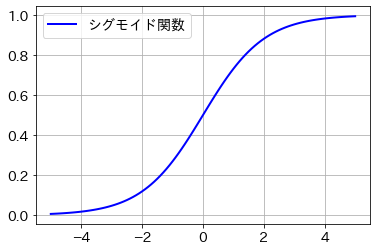

In [ ]:
# シグモイド関数の定義
def sigmoid(x):
  return 1/(1+np.exp(-x))


#xのデータの準備
x = np.linspace(-5, 5, 101)

#yのデータの準備
y=sigmoid(x)

# グラフの表示
plt.plot(x, y, label='シグモイド関数', c='b', lw=2)

#判例の表示
plt.legend()

#方眼表示
plt.grid()

#グラフの描画
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# 決定境界の表示関数
def plot_boundary(ax, x, y, algorithm):
    x_train, x_test, y_train, y_test = train_test_split(x, y,
            test_size=0.5, random_state=random_seed)
    # カラーマップ定義
    from matplotlib.colors import ListedColormap
    cmap1 = plt.cm.bwr
    cmap2 = ListedColormap(['#0000FF', '#000000'])

    h = 0.005
    algorithm.fit(x_train, y_train)
    score_test = algorithm.score(x_test, y_test)
    score_train = algorithm.score(x_train, y_train)
    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 1].min() - 0.5
    f2_max = x[:, 1].max() + 0.5
    f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, h), 
                         np.arange(f2_min, f2_max, h))
    if hasattr(algorithm, "decision_function"):
        Z = algorithm.decision_function(np.c_[f1.ravel(), f2.ravel()])
        Z = Z.reshape(f1.shape)
        ax.contour(f1, f2, Z, levels=[0], linewidth=2)
    else:
        Z = algorithm.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
        Z = Z.reshape(f1.shape)
    ax.contourf(f1, f2, Z, cmap=cmap1, alpha=0.3)
    ax.scatter(x_test[:,0], x_test[:,1], c=y_test, cmap=cmap2)
    ax.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=cmap2, marker='x')
    text = f'検証:{score_test:.2f}  訓練: {score_train:.2f}'
    ax.text(f1.max() - 0.3, f2.min() + 0.3, text, horizontalalignment='right',
    fontsize=18) 
    

In [ ]:
# 散布図と決定境界の表示関数

def plot_boundaries(algorithm, DataList):
    plt.figure(figsize=(15,4))
    for i, data in enumerate(DataList):
        X, y = data
        ax = plt.subplot(1, N, i+1)
        plot_boundary(ax, X, y, algorithm)
    plt.show()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


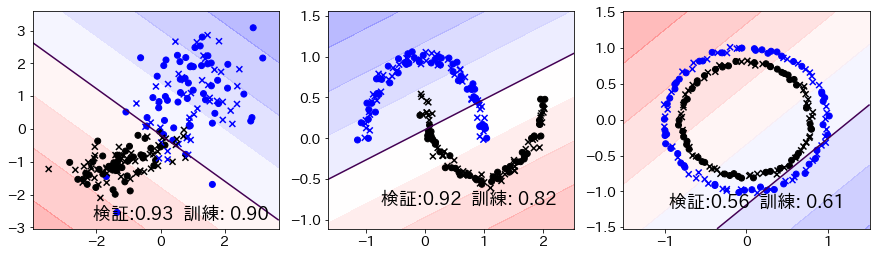

In [ ]:
# ロジスティック回帰の散布図・分類結果表示
# アルゴリズムの選択
from sklearn.linear_model import LogisticRegression
algorithm = LogisticRegression(random_state = random_seed)

#　アルゴリズムの持つパラメータの表示
print(algorithm)

#　表示関数の呼び出し
plot_boundaries(algorithm, DataList)

## サポートベクターマシン（カーネル型) [SVM]

 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


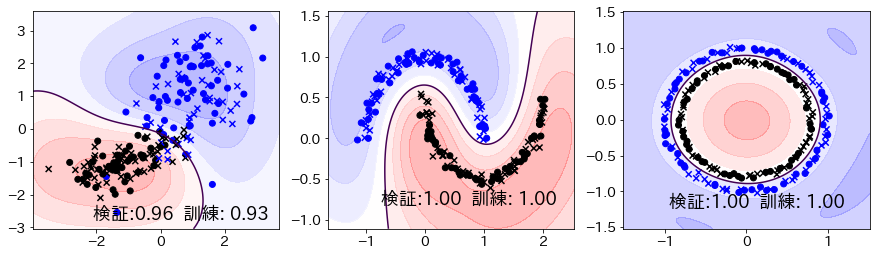

In [ ]:
# SVM(カーネル)の散布図・分類結果表示

# アルゴリズムの選択
from sklearn.svm import SVC
algorithm = SVC(kernel='rbf')

#アルゴリズムの持つパラメータの表示
print(algorithm)

#表示関数の呼び出し
plot_boundaries(algorithm, DataList)

## ニューラルネットワーク

　ニューラルネットワークは、脳の神経細胞（ニューロン）のネットワークをもして作られたアルゴリズム

この層が、２層、３層と複数にしていったものがディープラーニングになる

今回は sklearnのニューラルネットワークを使う

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


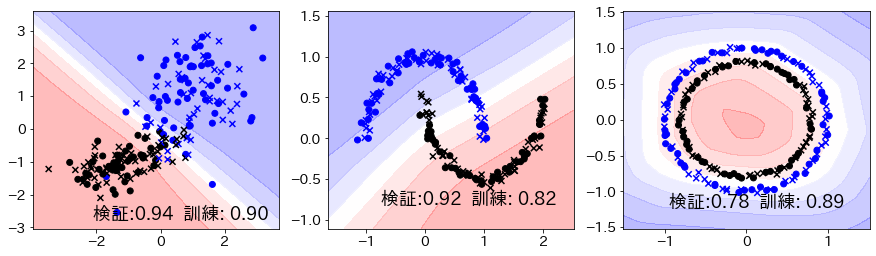

In [ ]:
# ニューラルネットワークの散布図・分類結果の表示

# アルゴリズムの選択
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier(random_state=random_seed)

# アルゴリズムの保つパラメータの表示
print(algorithm)

#　表示関数の呼び出し
plot_boundaries(algorithm, DataList)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


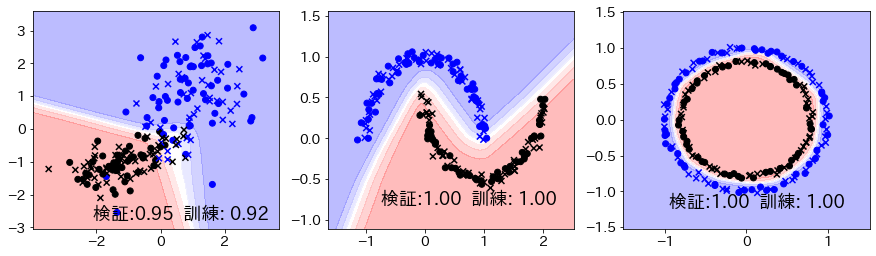

In [ ]:
# ニューラルネットワークの散布図・分類結果の表示

# アルゴリズムの選択　（NNの層を２層にする）
# 隠れ層のノード数 = (100, 100)
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=random_seed)

# アルゴリズムの保つパラメータの表示
print(algorithm)

#　表示関数の呼び出し
plot_boundaries(algorithm, DataList)

## 決定木

　　決定木型アルゴリズム

In [ ]:
# 追加ライブラリのimport
import seaborn as sns

#　サンプルデータの読み込み
df_iris = sns.load_dataset("iris")

# ２種類の花に絞り込み
df2 = df_iris[50:150]

# データ分離
X = df2.drop('species', axis=1)
y = df2['species']

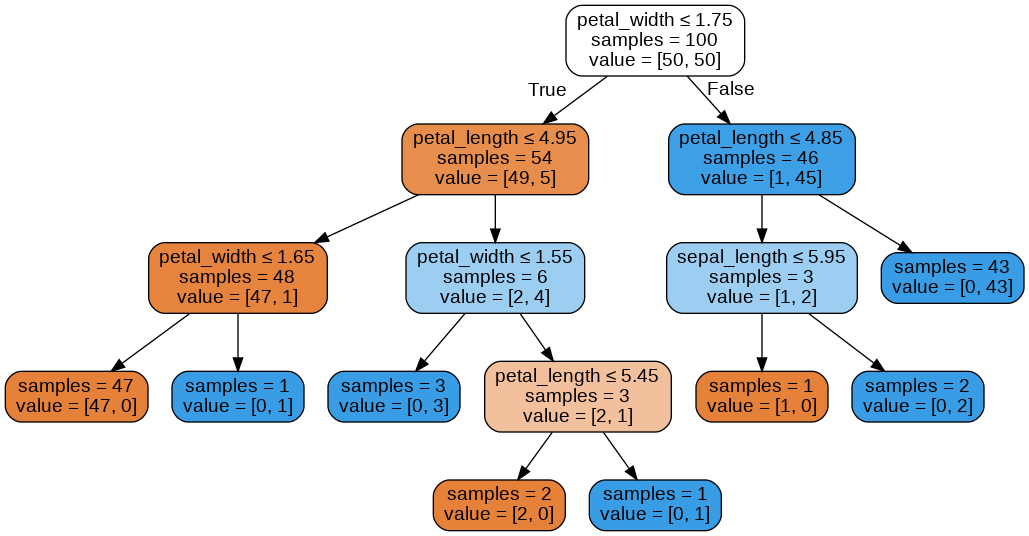

In [ ]:
# 学習
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=random_seed)
algorithm.fit(X, y)

# 決定木ツリーの表示
from sklearn import tree
with open('iris-dtree.dot', mode='w') as f:
  tree.export_graphviz(algorithm, out_file=f,
                       feature_names=X.columns, filled=True, rounded=True,
                       special_characters=True, impurity=False, proportion=False
                       )

import pydotplus
from IPython.display import Image
graph = pydotplus.graphviz.graph_from_dot_file('iris-dtree.dot')
graph.write_png('iris-dtree.png')
Image(graph.create_png())




DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


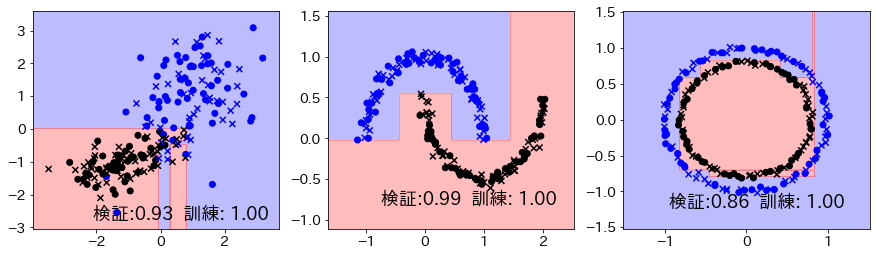

In [ ]:
# 決定木の散布図・分類結果の表示

# アルゴリズムの選択
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

今までの損失関数型アルゴリズムとの決定境界の比較

・SVM同様, 同心円状の決定協会にも対応可能 \\
・SVMの境界がなだらかな曲線だったのに対して, 決定木凶器アセンは、長方形の苦役領域を組み合わせた図形になる　\\
・例外値に対してもむりやり適合するルールを作るので、境界線が不自然な図形になる場合がある

例外値　ー＞　　「過学習」の可能性

　　過学習が発生すると、学習に使わなかたtデータに対する精度は逆になる可能性がある

　　ツリーの階層を深くすればするだけこの過学習の危険性が生じる \\
　
　そのため、パラメータにおける "max_depth" が重要となる

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


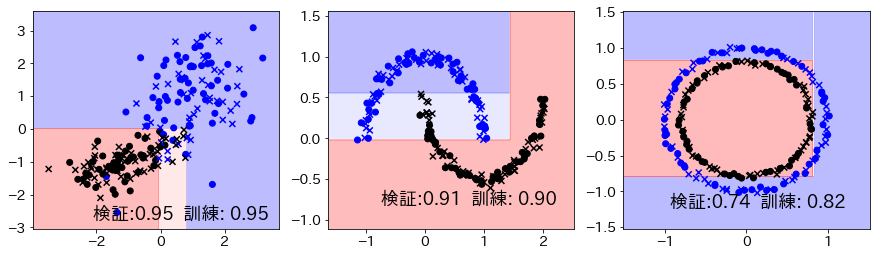

In [ ]:
# 決定木の散布図・分類結果の表示　（MaX＿depth＝3の場合）

# アルゴリズムの選択
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(max_depth=3, random_state=random_seed)

# アルゴリズムの持つパラメータの表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

##  ランダムフォレスト

　決定木　・・・　どのような性質のデータにも十何二対応できるが、過学習が起きやすい

　欠点を補うために考えられた方式が、　ランダムフォレストである

　「弱分類器」と呼ばれる簡易的な分類器を多く作り、それぞれの分類結果を集計して多数決で総合的な判断を行う

　 **弱分類器の結果を全部寄せ集めて多数決を撮ると、全体としては精度の良い分類ができる**

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


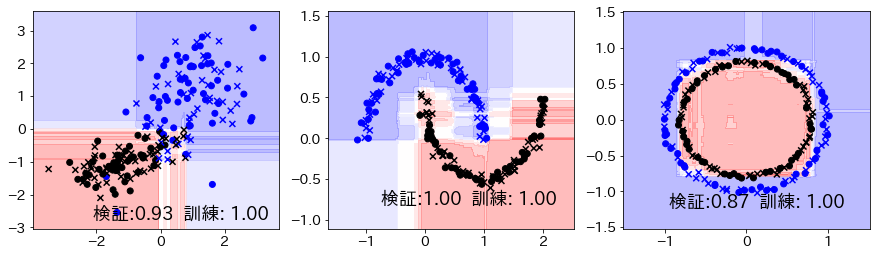

In [ ]:
# ランダムフォレストの散布図・分類結果表示

# アルゴリズムの選択
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)


## XGBoost

XGBoost (eXtream Gradient Boosting ) : 2014 に publish

**アンサンブル**と呼ばれる複数の決定木を使って分類するモデル

**バギング**と呼ばれる手法と **ブースティング**と呼ばれる手法を組み合わせたもの

　**バギング**　・・・　お互いに関係のない弱分類器を並列に作ってその結果を多数決で最終的な分類を行う方法

 **ブースティング** ・・・　複数の分類器を使う点ではバギングと同じだが、 バギングは複数の分類器が互いに無関係に学習するに対して, ブースティングは1つ前の分類器の結果を基にして次の
 分類器の学習をする

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


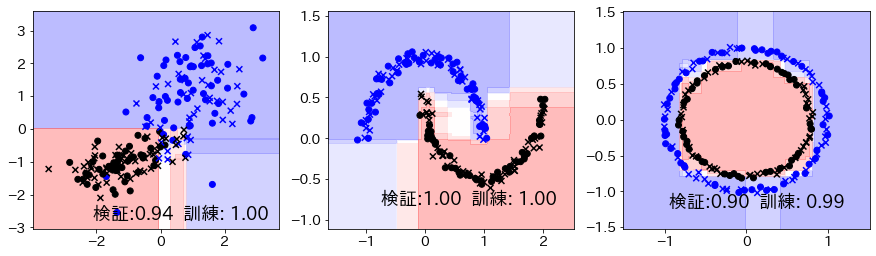

In [ ]:
# XGBoostの散布図・分類結果の表示

# アルゴリズムの選択
import xgboost
algorithm = xgboost.XGBClassifier(random_state=random_seed)

# アルゴリズムの持つパラメータの表示
print(algorithm)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

## アルゴリズムの選択

　問に関して, 簡単な答えを出すことは難しいので、以下の観点で基準を決めることが多い

**モデルの判断根拠を知りたい**

 「モデルがなぜその結果を出したか」を人間が追いかけることができるか？ \\
 　今回のロジスティック回帰や決定木のような場合は、　この点が重要とされ使われることが多い

 **高精度のモデル**

  「理由はわからなくて良いからできるだけ正確に予測したい」というケース　 \\
  
  サポートベクターマシン(SVM[kernel]), NN, ランダムフォレスト, XGBoostが選ばれることが多い

  精度をそのため比較することがよくある ・・・　**「交差検定法」や「グッドリサーチ」** 
  
  →　次の講義で説明

  **学習時間**

  今回の自習で使ったサンプルデータでは、データ件数や項目数（次元数）がすくないので、あまり意識しなくても良い。

  実プロジェクトでは、　件数が数千件, 項目数(次元数）が数百・数千となるけイースもある

  そのため、複雑なモデルの場合はどれくらい時間がかかるのかを考える必要がある
